In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from itertools import cycle, islice

In [2]:
# set chart style
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, 
                rc={"lines.linewidth": 1.5})
colors = ['#91268F','#F05A28','#8CC63E','#00A7A0','#4C4C4C',
          '#BFE9E7','#7a2700']
sns.set(font="Pragmatica")

In [3]:
df = pd.read_csv(r'..\..\..\outputs\network\network_results.csv')

# Congested network components by time of day
df.columns

# Get freeflow from 20to5 period

# Exclude trips taken on non-designated facilities (facility_type == 0)
# These are artificial (weave lanes to connect HOV) or for non-auto uses 
df = df[df['data3'] != 0]    # data3 represents facility_type

# calculate total link VMT and VHT
df['VMT'] = df['@tveh']*df['length']
df['VHT'] = df['@tveh']*df['auto_time']/60

# Define facility type
df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

# Calculate delay
# Select links from overnight time of day
delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

# Merge delay field back onto network link df
df = pd.merge(df, delay_df, on='ij', how='left')

# Calcualte hourly delay
df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

# Calcualte speed as a percent of freeflow
df['flow_index'] = df['auto_time']/df['freeflow_time']

df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})

# FGTS

# Non-motorized extent in geographies

# High Capacity Transit Network

In [4]:
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

# Congestion by County Tables
### Total VMT & Percent of County VMT by Congestion Level

- **Severe: < 25% Speed Limit** (e.g., less than 15 mph on a road with speed limit of 60 mph)
- **Heavy: 25-50% Speed Limit** (e.g., 15-30 mph on a road with speed limit of 60 mph)
- **Moderate: 50-70% Speed Limit** (e.g, 30-42 mph on a road with speed limit of 60 mph)

#### All Day

In [5]:
# Percent of VMT by congestion category
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"36,303,034","4,150,513","15,769,569","14,706,057"
Moderate,"5,530,430","86,550","1,614,766","1,201,415"
Heavy,"2,907,243","52,482","550,147","575,886"
Severe,"313,870","4,372","36,654","56,583"


In [6]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,80.6%,96.7%,87.7%,88.9%
Moderate,12.3%,2.0%,9.0%,7.3%
Heavy,6.5%,1.2%,3.1%,3.5%
Severe,0.7%,0.1%,0.2%,0.3%


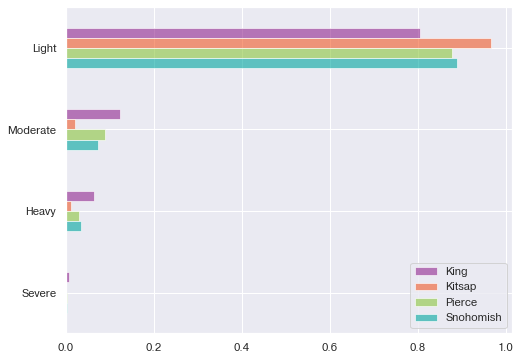

In [7]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

**Freeway** VMT by Congestion Category

In [8]:
# Segment by facility type
_df = df[df['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"17,819,467","1,712,473","6,615,676","6,711,858"
Moderate,"3,557,213","11,597","793,595","552,030"
Heavy,"1,866,886","16,868","184,834","226,338"
Severe,"116,068",335,"1,752","12,885"


**Arterial** VMT by Congestion Category

In [9]:
# Segment by facility type
_df = df[df['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"15,988,394","2,013,880","7,818,940","6,573,730"
Moderate,"1,973,216","74,954","821,171","649,385"
Heavy,"1,040,357","35,614","365,313","349,548"
Severe,"197,803","4,037","34,902","43,698"


#### AM Peak (7 to 8 AM)

In [10]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,207,625","296,882","992,555","957,381"
Moderate,"595,501","7,181","244,890","165,964"
Heavy,"523,938","8,455","89,130","88,341"
Severe,"51,461",284,"4,350","5,557"


In [11]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,65.3%,94.9%,74.6%,78.7%
Moderate,17.6%,2.3%,18.4%,13.6%
Heavy,15.5%,2.7%,6.7%,7.3%
Severe,1.5%,0.1%,0.3%,0.5%


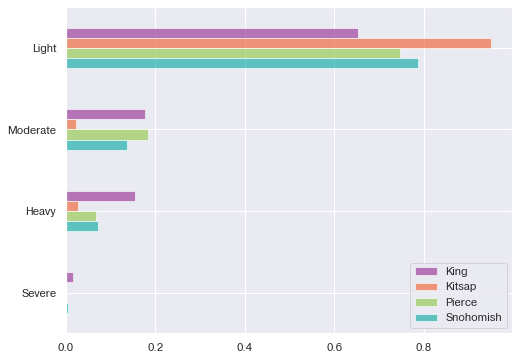

In [12]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

AM Peak **Freeway** VMT

In [13]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"945,952","135,374","383,879","443,125"
Moderate,"393,960","1,690","171,328","95,025"
Heavy,"408,579","5,974","50,469","58,123"
Severe,"29,428",0,0,781


AM Peak **Arterial** VMT

In [14]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,114,193","138,162","532,261","433,286"
Moderate,"201,541","5,491","73,561","70,938"
Heavy,"115,358","2,481","38,661","30,218"
Severe,"22,033",284,"4,350","4,776"


#### PM Peak (5 to 6 PM)

In [15]:
pd.options.display.float_format = '{:0,.0f}'.format
df_pm = df[df['tod'] == '17to18']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,207,625","296,882","992,555","957,381"
Moderate,"595,501","7,181","244,890","165,964"
Heavy,"523,938","8,455","89,130","88,341"
Severe,"51,461",284,"4,350","5,557"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,65.3%,94.9%,74.6%,78.7%
Moderate,17.6%,2.3%,18.4%,13.6%
Heavy,15.5%,2.7%,6.7%,7.3%
Severe,1.5%,0.1%,0.3%,0.5%


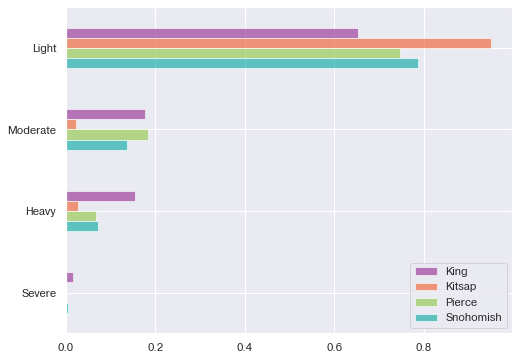

In [17]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

PM **Freeway** VMT

In [18]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,002,172","139,659","423,988","449,575"
Moderate,"424,645",0,"130,109","121,951"
Heavy,"379,124","5,089","52,773","34,443"
Severe,"26,339",170,484,"1,396"


PM **Arterial** VMT

In [19]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,294,479","166,513","623,548","507,990"
Moderate,"238,073","6,556","91,040","85,083"
Heavy,"136,513","3,599","47,338","41,008"
Severe,"26,819",536,"4,692","5,614"


# Freight Congestion
## All Trucks (Heavy & Medium)
#### All Day

In [20]:
df['heavy_truck_vmt'] = df['length']*df['@heavy_truck']
df['medium_truck_vmt'] = df['length']*df['@medium_truck']
df['total_truck_vmt'] = df['heavy_truck_vmt']+df['medium_truck_vmt'] 

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='total_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"4,988,897","462,377","1,878,556","1,894,462"
Moderate,"844,864","6,101","203,814","139,076"
Heavy,"406,584","3,904","50,052","46,990"
Severe,"28,719",248,"3,076","2,768"


In [22]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,79.6%,97.8%,88.0%,90.9%
Moderate,13.5%,1.3%,9.5%,6.7%
Heavy,6.5%,0.8%,2.3%,2.3%
Severe,0.5%,0.1%,0.1%,0.1%


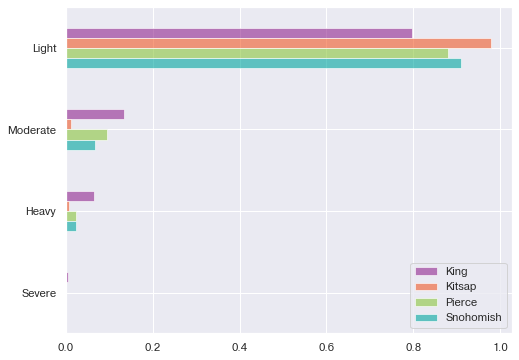

In [23]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Heavy Trucks

In [24]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='heavy_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,474,755","192,342","1,070,144","1,081,423"
Moderate,"407,183","1,681","114,686","68,137"
Heavy,"189,431","1,257","24,061","18,824"
Severe,"10,552",82,"1,498",456


In [25]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,80.3%,98.5%,88.4%,92.5%
Moderate,13.2%,0.9%,9.5%,5.8%
Heavy,6.1%,0.6%,2.0%,1.6%
Severe,0.3%,0.0%,0.1%,0.0%


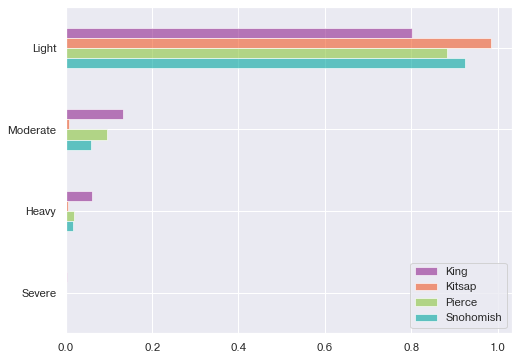

In [26]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Medium Trucks

In [27]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')

_df

county,King,Kitsap,Pierce,Snohomish
congestion_category,,,,
Severe,"18,167",166,"1,578","2,312"
Heavy,"217,153","2,647","25,990","28,166"
Moderate,"437,681","4,420","89,128","70,939"
Light,"2,514,143","270,036","808,412","813,039"


In [28]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,514,143","270,036","808,412","813,039"
Moderate,"437,681","4,420","89,128","70,939"
Heavy,"217,153","2,647","25,990","28,166"
Severe,"18,167",166,"1,578","2,312"


In [29]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,78.9%,97.4%,87.4%,88.9%
Moderate,13.7%,1.6%,9.6%,7.8%
Heavy,6.8%,1.0%,2.8%,3.1%
Severe,0.6%,0.1%,0.2%,0.3%


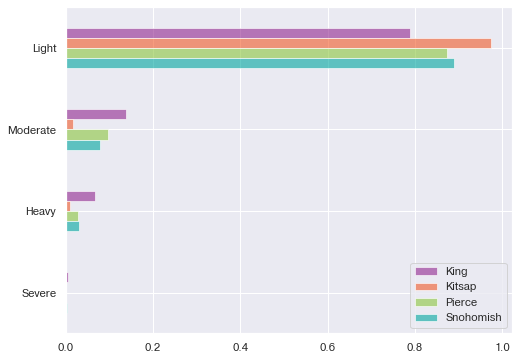

In [30]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');